# Предсказание температуры при обработке стали

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Общая-информация-о-данных" data-toc-modified-id="Общая-информация-о-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Общая информация о данных</a></span></li><li><span><a href="#Предобработка-и-исследовательский-анализ-данных" data-toc-modified-id="Предобработка-и-исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка и исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Данные-об-электродах" data-toc-modified-id="Данные-об-электродах-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Данные об электродах</a></span></li><li><span><a href="#Данные-о-подаче-сыпучих-материалов-(объём)" data-toc-modified-id="Данные-о-подаче-сыпучих-материалов-(объём)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Данные о подаче сыпучих материалов (объём)</a></span></li><li><span><a href="#Данные-о-продувке-сплава-газом" data-toc-modified-id="Данные-о-продувке-сплава-газом-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Данные о продувке сплава газом</a></span></li><li><span><a href="#Результаты-измерения-температуры" data-toc-modified-id="Результаты-измерения-температуры-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Результаты измерения температуры</a></span></li><li><span><a href="#Данные-о-проволочных-материалах-(объём)" data-toc-modified-id="Данные-о-проволочных-материалах-(объём)-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Данные о проволочных материалах (объём)</a></span></li></ul></li><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Исследование-моделей" data-toc-modified-id="Исследование-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Исследование моделей</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#Random-Forest-Regression" data-toc-modified-id="Random-Forest-Regression-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Random Forest Regression</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Результаты" data-toc-modified-id="Результаты-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Результаты</a></span></li></ul></li></ul></div>

В целях оптимизации производственных расходов, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

<b>Описание этапа обработки:</b>

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

<b>Условия задачи:</b>
* Метрика - MAE
* RANDOM_STATE = 12092022
* Тестовая выборка - 20%
* Обязательно используем подбор параметров только с использованием GridSearchCV или RandomizedSearchCV.

<b>План работы:</b>

1. Загрузка данных, предобработка и анализ данных;
2. Объединение таблиц с признаками по ключу `key` (inner join), выделение целевого признака (конечная температура);
3. Исследование разных регрессионных моделей (линейная, случайный лес, бустинг), выбор лучшей;
4. Проверка лучшей модели на тестовой выборке.

In [1]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool

In [2]:
state = np.random.RandomState(12092022) #объект RandomState для дальнейшего использования по всему проекту

## Общая информация о данных

Таблицы `data_bulk_time.csv` и `data_wire_time.csv` не смотрим - данные в них некорректны.

In [3]:
#чтение файлов с данными и сохранение в переменные
data_arc = pd.read_csv('data_arc.csv')
data_bulk = pd.read_csv('data_bulk.csv')
data_gas = pd.read_csv('data_gas.csv')
data_temp = pd.read_csv('data_temp.csv')
data_wire = pd.read_csv('data_wire.csv')

In [4]:
data_arc.info() #получение информации о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [5]:
data_arc.head() #вывод первых 5 строк

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [6]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [7]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [8]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [9]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [10]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [11]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [12]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [13]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<b>Вывод:</b> Необходимо заполнить пропуски в данных, проверить на дубликаты, изменить названия столбцов в соответствии с общепринятыми правилами.

## Предобработка и исследовательский анализ данных

Изменяем названия столбцов:

In [14]:
data_arc = data_arc.rename(columns={
    "Начало нагрева дугой": "arc_heating_start",
    "Конец нагрева дугой": "arc_heating_finish",
    "Активная мощность": "active_power",
    "Реактивная мощность": "reactive_power"
})

data_bulk.columns = data_bulk.columns.str.lower()
data_bulk.columns = data_bulk.columns.str.replace(' ','_')

data_gas = data_gas.rename(columns={"Газ 1": "gas_1"})

data_temp = data_temp.rename(columns={
    "Время замера": "measurement_time",
    "Температура": "temperature"
})

data_wire.columns = data_wire.columns.str.lower()
data_wire.columns = data_wire.columns.str.replace(' ','_')

### Данные об электродах

In [15]:
data_arc[['active_power', 'reactive_power']].describe()

,active_power,reactive_power
count,14876.000000,14876.000000
mean,0.670441,0.452592
std,0.408159,5.878702
min,0.030002,-715.504924
25%,0.395297,0.290991
50%,0.555517,0.415962
75%,0.857034,0.637371
max,3.731596,2.676388


Данные с отрицательным значением мощности удаляем:

In [16]:
data_arc = data_arc.drop(data_arc[data_arc['reactive_power'] < 0].index)

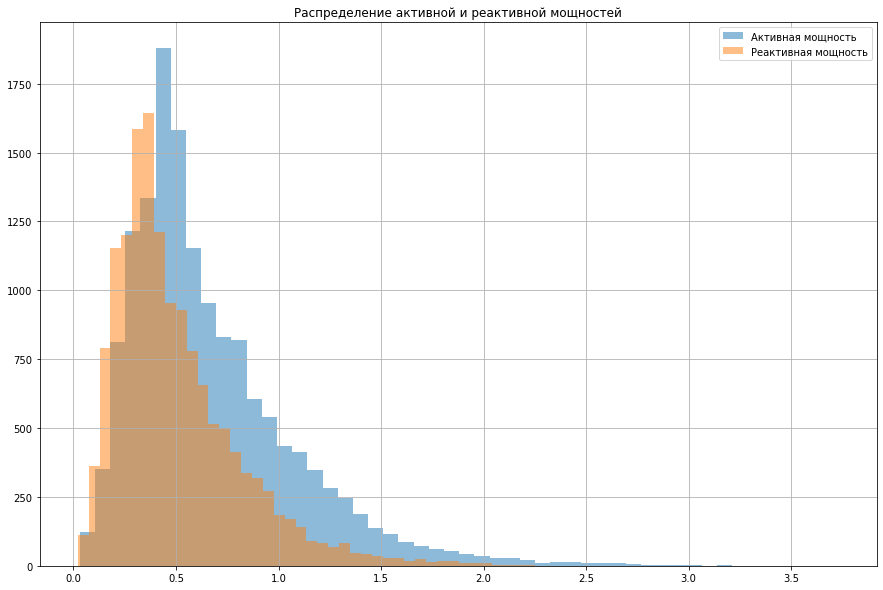

In [17]:
plt.figure(figsize=(15, 10))
plt.hist(data_arc['active_power'], bins=50, alpha=0.5, label='Активная мощность')
plt.hist(data_arc['reactive_power'], bins=50, alpha=0.5, label='Реактивная мощность')
plt.legend(loc='upper right')
plt.title('Распределение активной и реактивной мощностей')
plt.grid()
plt.show()

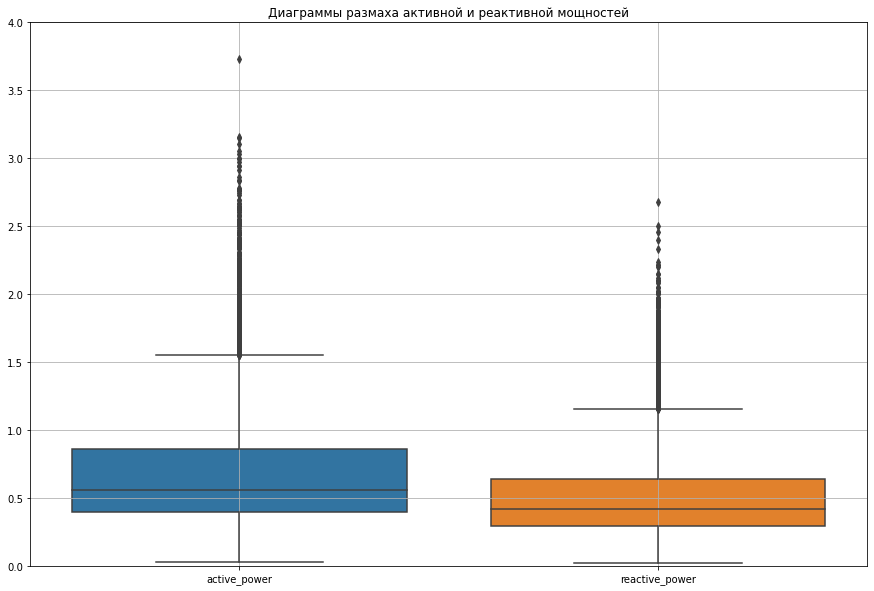

In [18]:
plt.figure(figsize=(15, 10))
plt.ylim(0, 4)
sns.boxplot(data=data_arc[['active_power', 'reactive_power']])
plt.title('Диаграммы размаха активной и реактивной мощностей')
plt.grid()
plt.show()

Распределение напоминает нормальное, данные для реактивной мощности смещены влево относительно активной.

Пропусков и дубликатов нет:

In [19]:
data_arc.isna().value_counts()

key    arc_heating_start  arc_heating_finish  active_power  reactive_power
False  False              False               False         False             14875
dtype: int64

In [20]:
data_arc.duplicated().value_counts()

False    14875
dtype: int64

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА</b></u></p>
И графический анализ на месте. ОК.

### Данные о подаче сыпучих материалов (объём)

In [21]:
data_bulk.drop('key', axis=1).describe()

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


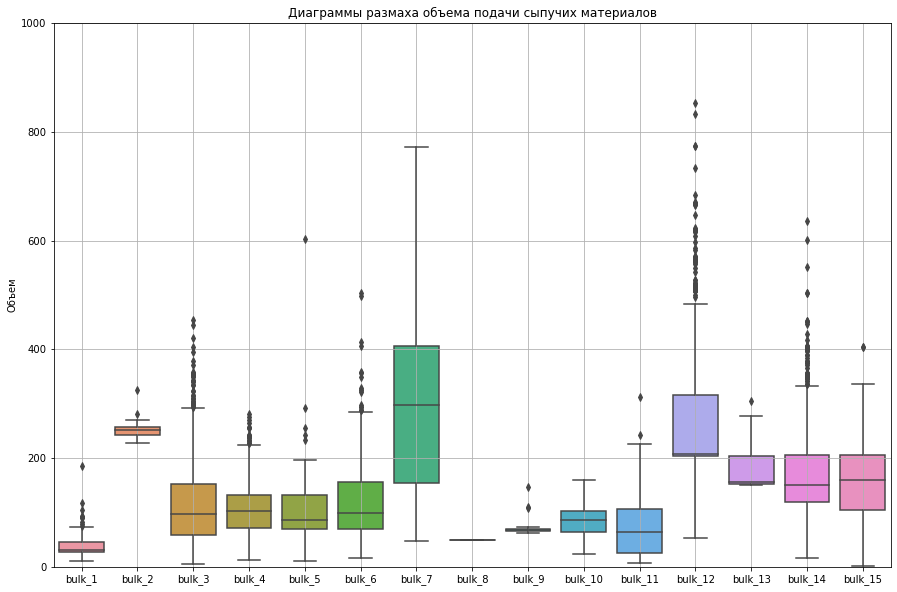

In [22]:
plt.figure(figsize=(15, 10))
plt.ylim(0, 1000)
sns.boxplot(data=data_bulk.drop('key', axis=1))
plt.title('Диаграммы размаха объема подачи сыпучих материалов')
plt.ylabel('Объем')
plt.grid()
plt.show()

Серьезных аномалий не замечено, хотя у bulk_5 и bulk_12 есть значения, значительно выходящие за "усы" (~600 и ~1800 соответственно). По распределениям можно сказать, что у объема подачи материалов есть шаг, наблюдается периодичность пиков. Также видно, что засыпается разное количество разного материала.

В датасете `data_bulk` есть пропуски. Т. к. в этом датасете содержится информация о количестве сыпучих примесей, поданных в определенный момент времени, то пропуск означает, что этот момент примеси не добавлялись. Следовательно, заменим пропуски нулями.

In [23]:
data_bulk = data_bulk.fillna(0)

Дубликатов нет:

In [24]:
data_bulk.duplicated().value_counts()

False    3129
dtype: int64

### Данные о продувке сплава газом

In [25]:
data_gas['gas_1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: gas_1, dtype: float64

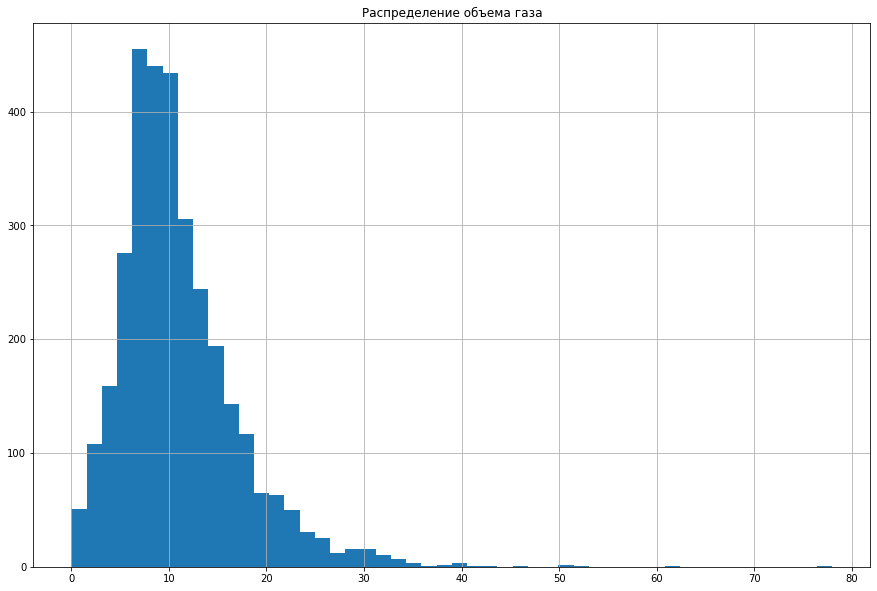

In [26]:
plt.figure(figsize=(15, 10))
plt.hist(data_gas['gas_1'], bins=50)
plt.title('Распределение объема газа')
plt.grid()
plt.show()

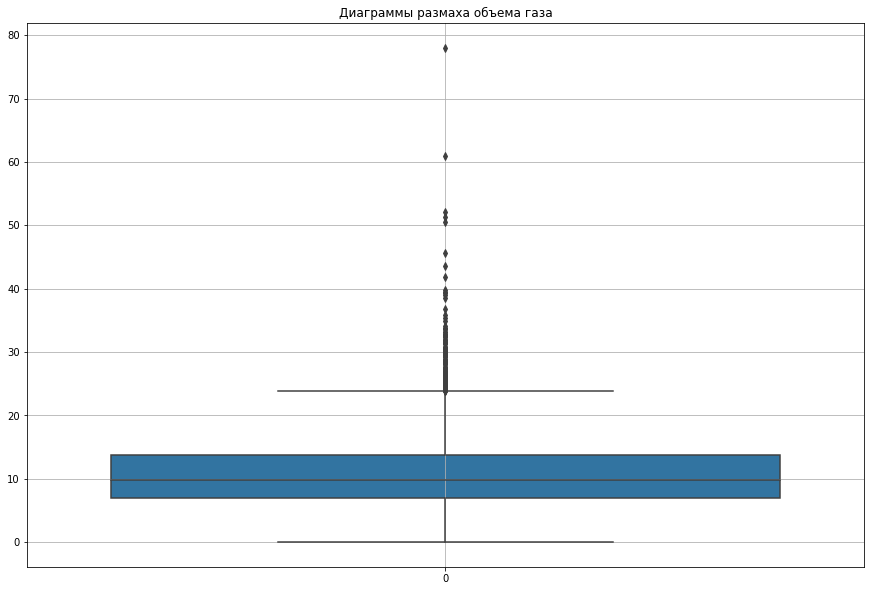

In [27]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=data_gas['gas_1'])
plt.title('Диаграммы размаха объема газа')
plt.grid()
plt.show()

Распределение напоминает нормальное, аномалий не выявлено, пропусков и дубликатов нет:

In [28]:
data_gas.isna().value_counts()

key    gas_1
False  False    3239
dtype: int64

In [29]:
data_gas.duplicated().value_counts()

False    3239
dtype: int64

### Результаты измерения температуры

В таблице `data_temp` есть пропуски:

In [30]:
data_temp.isna().value_counts()

key    measurement_time  temperature
False  False             False          13006
                         True            2901
dtype: int64

В данном датасете содержатся признак (начальная температура) и целевой признак (конечная температура). Необходимо выделить их из данных, а затем обработать пропуски. Однако, сначала необходимо убедиться в корректности этих данных, исходя из условий:

* Время измерения конечной температуры не может быть позже времени окончания нагрева дугой;
* Нет данных с одинаковой температурой в начале и в конце процесса.

In [31]:
keys_blacklist = []

for key in list(data_temp['key'].unique()):
    try:
        if ((data_temp[data_temp['key'] == key]['measurement_time'].max() <
        data_arc[data_arc['key'] == key]['arc_heating_finish'].max()) or
        (data_temp[data_temp['key'] == key]['measurement_time'].max() ==
        data_temp[data_temp['key'] == key]['measurement_time'].min())):
            keys_blacklist.append(key)
    except:
        keys_blacklist.append(key)

In [32]:
len(keys_blacklist)

171

Удаляем данные котлов, попавших в черный список:

In [33]:
data_temp = data_temp.query('key not in @keys_blacklist')

Разделяем начальную и конечную температуры:

In [34]:
start_time_list = list(data_temp.pivot_table(index='key', values='measurement_time', aggfunc={'min', 'max'})['min'])
finish_time_list = list(data_temp.pivot_table(index='key', values='measurement_time', aggfunc={'min', 'max'})['max'])

data_temp_start = data_temp.query('measurement_time in @start_time_list ').reset_index(drop=True) #датафрейм с начальными температурами
data_temp_finish = data_temp.query('measurement_time in @finish_time_list ').reset_index(drop=True) #датафрейм с финальными температурами

Проверим пропуски:

In [35]:
data_temp_start.isna().value_counts()

key    measurement_time  temperature
False  False             False          3045
dtype: int64

In [36]:
data_temp_finish.isna().value_counts()

key    measurement_time  temperature
False  False             False          2344
                         True            701
dtype: int64

Видим, что в датафрейме с конечными температурами есть много пропусков. Удалим их:

In [37]:
data_temp_finish = data_temp_finish.dropna()

In [38]:
data_temp_finish.isna().value_counts()

key    measurement_time  temperature
False  False             False          2344
dtype: int64

Проверка на дубликаты:

In [39]:
data_temp_start.duplicated().value_counts()

False    3045
dtype: int64

In [40]:
data_temp_finish.duplicated().value_counts()

False    2344
dtype: int64

In [41]:
data_temp_start['temperature'].describe()

count    3045.000000
mean     1588.574384
std        29.285448
min      1191.000000
25%      1572.000000
50%      1588.000000
75%      1606.000000
max      1684.000000
Name: temperature, dtype: float64

In [42]:
data_temp_finish['temperature'].describe()

count    2344.000000
mean     1595.328925
std        15.774437
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1599.000000
max      1700.000000
Name: temperature, dtype: float64

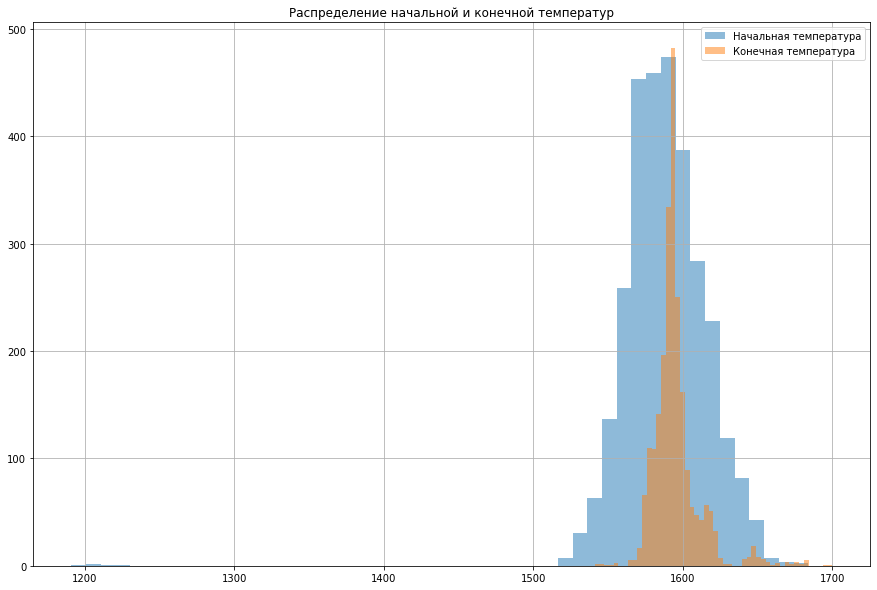

In [43]:
plt.figure(figsize=(15, 10))
plt.hist(data_temp_start['temperature'], bins=50, alpha=0.5, label='Начальная температура')
plt.hist(data_temp_finish['temperature'], bins=50, alpha=0.5, label='Конечная температура')
plt.legend(loc='upper right')
plt.title('Распределение начальной и конечной температур')
plt.grid()
plt.show()

In [44]:
data_temp_start = data_temp_start.drop(data_temp_start[data_temp_start['temperature'] < 1450].index, axis=0)

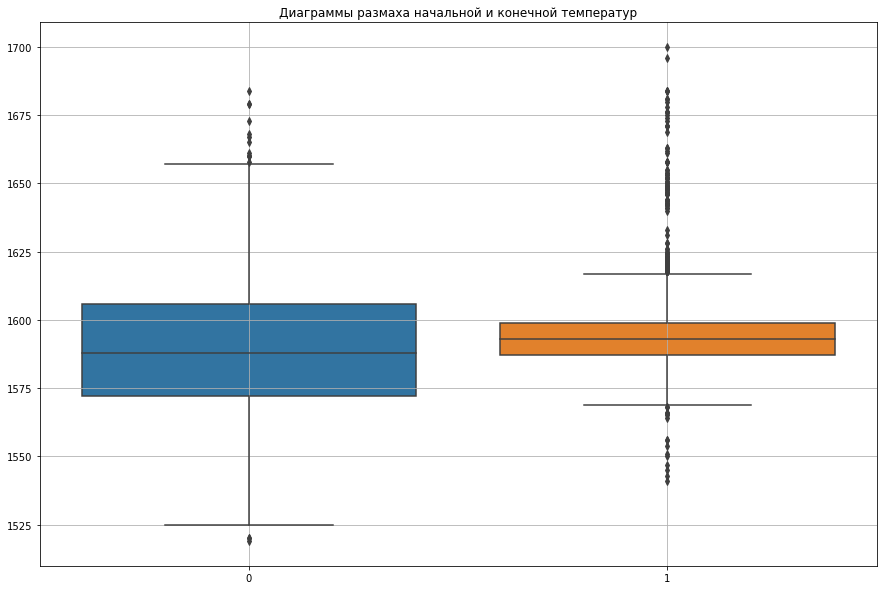

In [45]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=[data_temp_start['temperature'], data_temp_finish['temperature']])
plt.title('Диаграммы размаха начальной и конечной температур')
plt.grid()
plt.show()

Распределение температур нормальное, оптимальная конечная температура составляет около 1590 градусов. В распределении начальной температуры есть несколько выбросов (~1200 градусов), в распределении конечных температур таких выбросов нет.

### Данные о проволочных материалах (объём)

In [46]:
data_wire.drop('key', axis=1).describe()

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [47]:
data_wire = data_wire.drop('wire_5', axis=1)

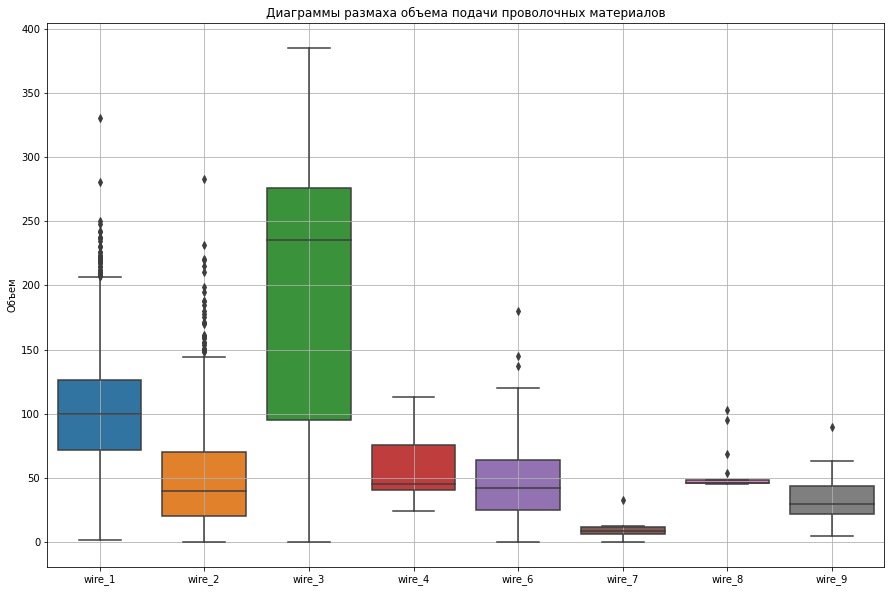

In [48]:
plt.figure(figsize=(15, 10))
#plt.ylim(0, 1000)
sns.boxplot(data=data_wire.drop('key', axis=1))
plt.title('Диаграммы размаха объема подачи проволочных материалов')
plt.ylabel('Объем')
plt.grid()
plt.show()

Материалы wire_1 и wire_2 добавляют значительно чаще других. У материала wire_3 широкий разброс по поданному объему. Аномалий не обнаружено.

В датасете `data_wire` также есть пропуски. Пропуск означает, что в данный момент времени проволока не подавалась в ковш, следовательно, можно заменить пропуск нулями:

In [49]:
data_wire = data_wire.fillna(0)

Проверяем дубликаты:

In [50]:
data_wire.duplicated().value_counts()

False    3081
dtype: int64

<b>Вывод:</b> Провели первичную проверку и анализ данных, избавились от пропусков, привели названия столбцов к snake case.

## Подготовка признаков

Проводим объединение таблиц, начиная с данных по температурам. Объединение проводим по методу `inner`, чтобы учесть только по тем котлам, для которых есть даннные.

In [51]:
final_data = data_temp_finish[['key', 'temperature']]
final_data = pd.merge(final_data, data_temp_start[['key', 'temperature']], on='key', how='inner')
final_data = final_data.rename(columns={
    "temperature_x": "final_temperature",
    "temperature_y": "start_temperature"
})

Данные с мощностью трансформируем в энергию. Если допустить, что мощность была постоянной за указанный период времени (или если указана средняя), то затраченную энергию на нагрев можно получить умножением мощности на временной интервал.

In [52]:
data_arc['time'] = (pd.to_datetime(data_arc['arc_heating_finish']) - pd.to_datetime(data_arc['arc_heating_start'])).dt.total_seconds()
data_arc['active_energy'] = data_arc['active_power'] * data_arc['time']
data_arc['reactive_energy'] = data_arc['reactive_power'] * data_arc['time']
data_arc_features = pd.pivot_table(data_arc, values=['active_energy','reactive_energy'], index='key', aggfunc='sum').reset_index()

data_arc_features.head()

,key,active_energy,reactive_energy
0,1,1207.804249,787.907510
1,2,733.816470,487.590677
2,3,443.583327,280.936835
3,4,670.663327,429.935932
4,5,997.496095,664.940090


In [53]:
final_data = pd.merge(final_data, data_arc_features[['key', 'active_energy', 'reactive_energy']], on='key', how='inner')
final_data = pd.merge(final_data, data_bulk, on='key', how='inner')
final_data = pd.merge(final_data, data_gas, on='key', how='inner')
final_data = pd.merge(final_data, data_wire, on='key', how='inner')

final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2206 entries, 0 to 2205
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2206 non-null   int64  
 1   final_temperature  2206 non-null   float64
 2   start_temperature  2206 non-null   float64
 3   active_energy      2206 non-null   float64
 4   reactive_energy    2206 non-null   float64
 5   bulk_1             2206 non-null   float64
 6   bulk_2             2206 non-null   float64
 7   bulk_3             2206 non-null   float64
 8   bulk_4             2206 non-null   float64
 9   bulk_5             2206 non-null   float64
 10  bulk_6             2206 non-null   float64
 11  bulk_7             2206 non-null   float64
 12  bulk_8             2206 non-null   float64
 13  bulk_9             2206 non-null   float64
 14  bulk_10            2206 non-null   float64
 15  bulk_11            2206 non-null   float64
 16  bulk_12            2206 

Проверяем мультиколлинеарность признаков:

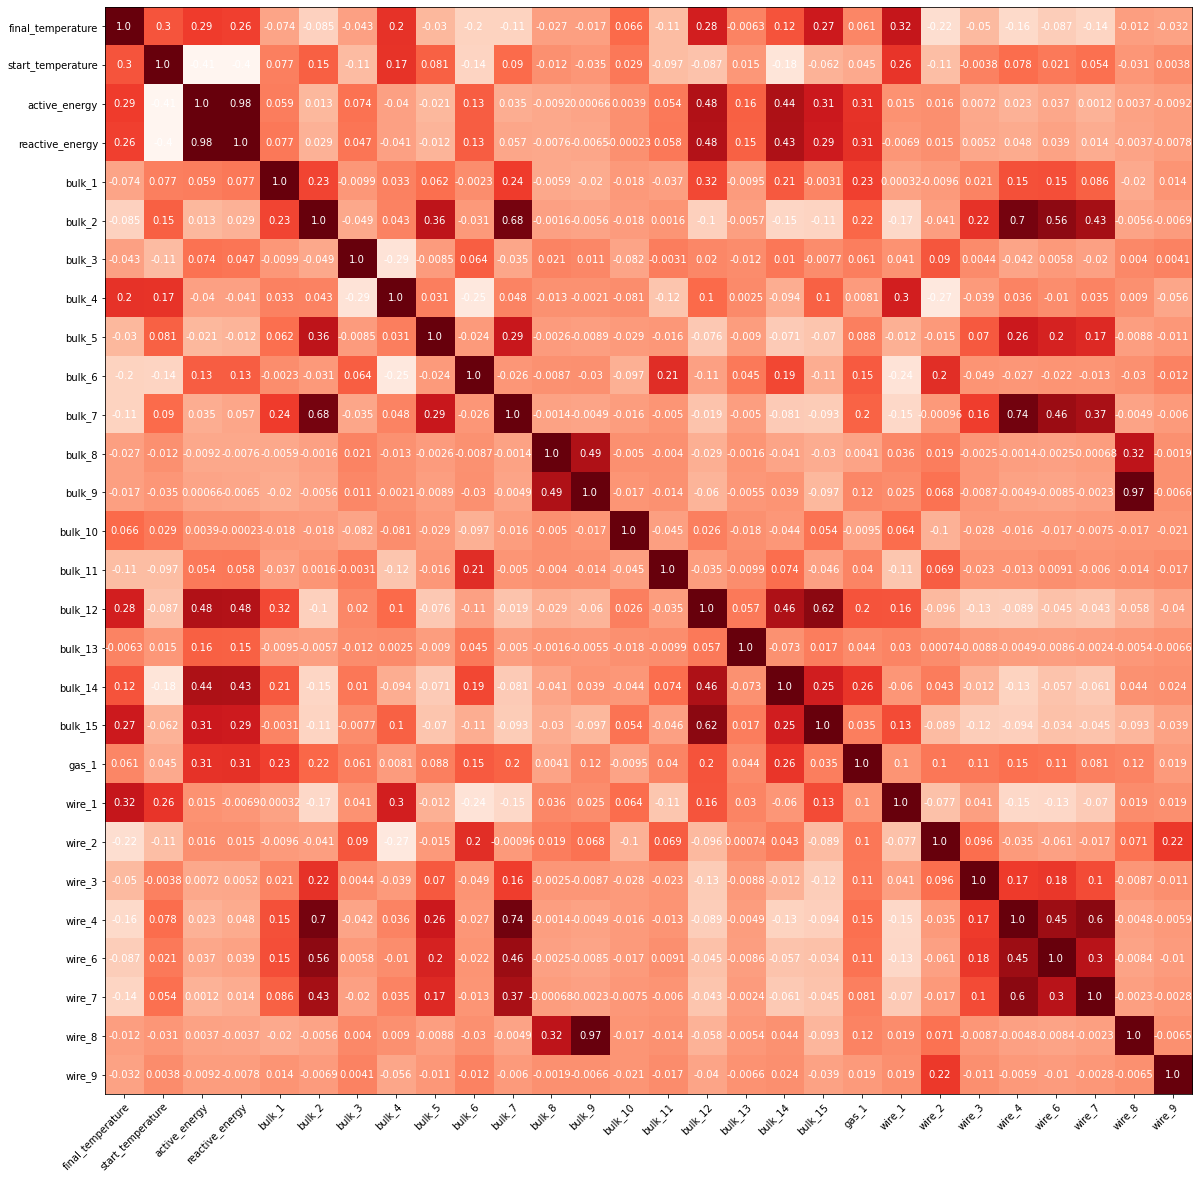

In [54]:
corr_heatmap_data = final_data.drop('key', axis=1).corr()

fig, ax = plt.subplots(figsize=(20,20))
ax.set_xticks(np.arange(len(corr_heatmap_data.index)))
ax.set_yticks(np.arange(len(corr_heatmap_data.index)))

ax.set_xticklabels(corr_heatmap_data.index)
ax.set_yticklabels(corr_heatmap_data.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

data = corr_heatmap_data.values

for i in range(len(corr_heatmap_data.index)):
    for j in range(len(corr_heatmap_data.index)):
        text = ax.text(j, i, '{:.2}'.format(data[i, j]),
                       ha="center", va="center", color="w")
        
im = ax.imshow(corr_heatmap_data.corr(), cmap='Reds')

Видим что между собой сильно коррелируют столбцы `active_energy` и `reactive_energy` (что логично), а также `bulk_9` и `wire_8`. Отбрасываем лишние данные:

In [55]:
final_data = final_data.drop(['key', 'reactive_energy', 'wire_8'], axis=1)

Выберем данные, на которых будем обучать модели. Оставим признаки, которе соответсуют следующим условиям:

* Линейный коэффициент корреляции признака и целевого признака должен быть больше 0.1;
* Количество ненулевых данных в столбцах должно быть больше 50% (важно для данных bulk и wire, модель, обученная на большом количестве нулевых значений, может неадекватно себя вести при появлении данных для признака)

In [56]:
features_whitelist = []

for column in final_data.columns:
    if ((len(final_data[final_data[column] != 0]) > final_data.shape[0] / 2) and
    (final_data[column].corr(final_data['final_temperature']) > 0.1)):
        features_whitelist.append(column)
        
features_whitelist       

['final_temperature',
 'start_temperature',
 'active_energy',
 'bulk_12',
 'bulk_14',
 'bulk_15',
 'wire_1']

In [57]:
final_data = final_data[features_whitelist] #итоговый набор данных для обучения

Формируем признаки:

In [58]:
features = final_data.drop('final_temperature', axis=1) #признаки тренировочной выборки
target = final_data['final_temperature'] #целевые признаки тренировочной выборки

In [59]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=state) #разделение датасета на тестовую и валидационную+тестовую выборки

In [60]:
print("Размер тренировочной выборки с признаками: ", features_train.shape)
print("Размер тренировочной выборки с целевым признаком: ", target_train.shape)
print("Размер тестовой выборки с признаками: ", features_test.shape)
print("Размер тестовой выборки с целевым признаком: ", target_test.shape)

Размер тренировочной выборки с признаками:  (1764, 6)
Размер тренировочной выборки с целевым признаком:  (1764,)
Размер тестовой выборки с признаками:  (442, 6)
Размер тестовой выборки с целевым признаком:  (442,)


## Исследование моделей

In [61]:
#функция обучения модели и получения метрики
def model_run(model, features, target):
    model.fit(features, target)
    predictions = model.predict(features)
    MAE = mean_absolute_error(target, predictions)
    return MAE

In [62]:
#заготовка для итоговой таблицы
ml_models_summary = pd.DataFrame(columns=['Model', 'MAE', 'Parameters'])

model_name_list = []
mae_list = []
comment_list = []

def summary_fill(model_name, mae, comment):
    model_name_list.append(model_name)
    mae_list.append(mae)
    comment_list.append(comment)
    return

### Linear Regression

Масштабируем признаки для линейной регрессии:

In [63]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train_scaled = scaler.transform(features_train)

In [64]:
lr = LinearRegression()
MAE = model_run(lr, features_train_scaled, target_train)
summary_fill('Linear Regression', MAE, 'N/A')
print('Mean absolute error: ', MAE)

Mean absolute error:  6.7596944944347435


### Random Forest Regression

Подбор гиперпараметров для случайного леса:

In [65]:
%%time

#словарь варьируемых гиперпараметров для функции GridSearchCV
param_dict = {'max_depth': range(1, 5), 'n_estimators': range(100, 301, 10)}

model = RandomForestRegressor(random_state=state)
grid = GridSearchCV(model, param_dict, n_jobs=-1, cv=5)
grid.fit(features_train, target_train)
print('Подобранные параметры: ', grid.best_params_)

Подобранные параметры:  {'max_depth': 4, 'n_estimators': 260}
Wall time: 24.1 s


In [66]:
RF_DEPTH = grid.best_params_['max_depth']
RF_ESTIMATORS = grid.best_params_['n_estimators']

In [67]:
%%time

rfr = RandomForestRegressor(max_depth=RF_DEPTH, n_estimators=RF_ESTIMATORS, random_state=state)
MAE = model_run(rfr, features_train, target_train)
summary_fill('Random Forest', MAE, f'depth = {RF_DEPTH}, n_estimators = {RF_ESTIMATORS}')
print('Mean absolute error: ', MAE)

Mean absolute error:  6.3338646343316265
Wall time: 541 ms


### CatBoost

In [68]:
train_data = Pool(data=features_train, label=target_train)
cat = CatBoostRegressor(eval_metric='MAE', logging_level='Silent', random_state=12092022)
grid = {'learning_rate': [0.01, 0.03, 0.05, 0.07],
        'depth': [2, 4, 6, 8, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}
grid_search_result = cat.grid_search(grid, train_data, verbose=False, cv=5)

In [69]:
MAE = model_run(cat, features_train, target_train)
summary_fill('CatBoost', MAE, grid_search_result['params'])
print('Mean absolute error: ', MAE)

Mean absolute error:  5.757697132065376


### Результаты

Суммарная таблица с результатами моделей:

In [70]:
ml_models_summary['Model'] = model_name_list
ml_models_summary['MAE'] = mae_list
ml_models_summary['Parameters'] = comment_list
ml_models_summary.sort_values(by='MAE', ascending=True)

,Model,MAE,Parameters
2,CatBoost,5.757697,"{'depth': 2, 'l2_leaf_reg': 1, 'learning_rate'..."
1,Random Forest,6.333865,"depth = 4, n_estimators = 260"
0,Linear Regression,6.759694,N/A


CatBoost стала лучшей моделью на тренировочной выборке по метрике MAE.

Оценка важности признаков лучшей модели:

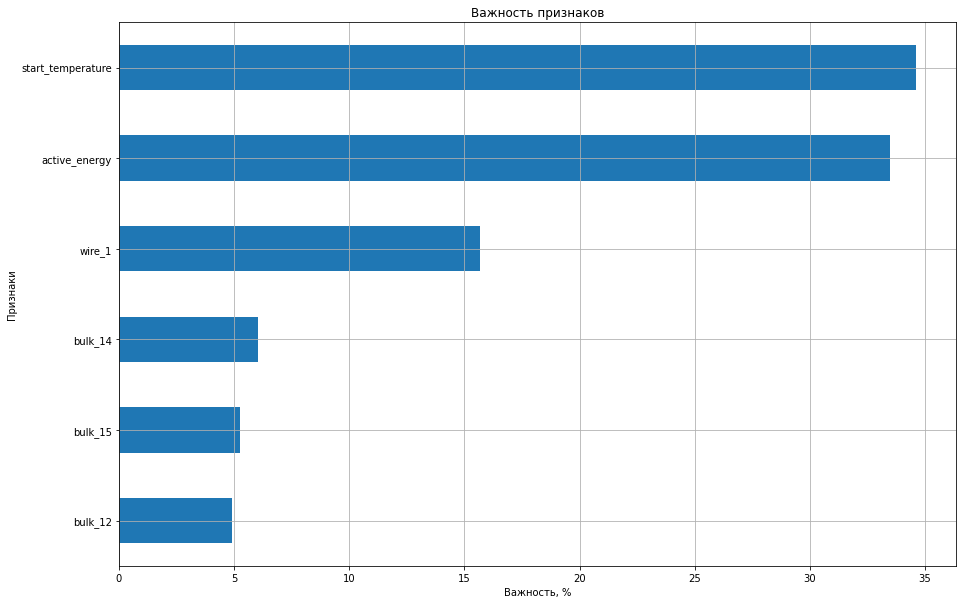

In [71]:
score_list = []
i = 0

for column in features_train.columns:
    score_list.append(cat.feature_importances_[i])
    i += 1
    
lr_score = pd.DataFrame(data=score_list, index=features_train.columns, columns=['score'])

lr_score.sort_values(by='score').plot(kind='barh', grid=True, figsize=(15,10), legend=False)
plt.title('Важность признаков')
plt.ylabel('Признаки')
plt.xlabel('Важность, %')
plt.show()

Видим, что наиболее важными признаками модели являются начальная температура и затраченная энергия на нагрев. Влияние сыпучих и проволочных материалов на модель зависит от их количества и теплоемкости.

Оценим лучшую модель на тестовой выборке:

In [72]:
predictions_test = cat.predict(features_test)
MAE_test = mean_absolute_error(target_test, predictions_test)
print('Mean absolute error (test): ', MAE_test)

Mean absolute error (test):  5.881207576438141


<b>Вывод:</b> таким образом, в данной работе было исследовано 3 модели:
* Линейная регрессия
* Случайный лес
* CatBoost

Лучший результат на тестовой выборке показала модель CatBoost (MAE = 5.76). Для данной модели были исследованы наиболее важные признаки, ими оказались начальная температура и затраченная энергия. На тестовой выборке модель показала MAE = 5.88, что является хорошим результатом в рамках данной задачи.

Видим, что наиболее важными признаками являются начальная температура и энергия, затраченная на нагрев. Отметим, что материалы, подаваемые в котел, также могут вносить значительный вклад в итоговую температуру. Прежде всего, это зависит от объема и теплоёмкости материалов, а также возможных химических реакций с поглощением и выделением теплоты (данный вопрос требует уточнения у технологов).